#Programación dinámica y la ecuación de Bellman

### Principio de Optimalidad de Bellman

La teoría del control óptimo depende en gran medida de la ecuación de Bellman. Esta ecuación se puede derivar del principio de optimalidad de Bellman:

>Principio de Optimalidad: Una política óptima tiene la propiedad de que cualesquiera que sean el estado inicial y la decisión inicial, las decisiones restantes deben constituir una política óptima con respecto al estado resultante de la primera decisión.

Sea $F(x,a)$ el costo de tomar la acción $a$ estando en el estado $x$. Entonces, el costo total se puede expresar como:
    
$$V(x_0) = \min_{{\{a_k}\}_{k=0}^N} \sum_{k=0}^N F(x_k, a_k)$$

Ahora podemos separar el primer paso de los demás. Esto es equivalente al principio de optimalidad de Bellman.

$$ V(x_0) = \min_{a_0} ( F(x_0, a_0) + \min_{{\{a_k}\}_{k=1}^N} \sum_{k=1}^N F(x_k, a_k))$$

Notamos que esto se trata de una ecuación recursiva:
$$ V(x_0) = \min_{a_0} ( F(x_0, a_0) + V(x_1) ),$$
la cual puede ser resuelta usando programación dinámica

1. Comience en el punto final deseado.
2. Realice todas las acciones posibles en el punto final, registrando su costo.
3. Para los estados resultantes de las acciones realizadas, vuelva a realizar todas las acciones.
4. Si se puede alcanzar un estado mediante más de una secuencia de acciones, elija la secuencia de acciones con el menor costo.
5. Repita el proceso hasta que se alcance el estado inicial mediante una secuencia de acciones (cuyo costo sea menor que cualquier otra secuencia de acciones que pueda alcanzar el estado inicial).

### Generación de terreno

In [1]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import math

Populating the interactive namespace from numpy and matplotlib


Resolvamos el problema de calcular el camino más corto a través de un terreno montañoso. Generaremos el terreno mediante una suma de gaussianos.

In [4]:
# Modelo de terreno
def terrain(x):
    peaks = [# center, height, sigma
             ((0.3,0.4), 2, 0.1),
             ((1.0,0.0), 1, 0.1),
             ((0.5,0.5), 1, 0.1),
             ((0.0,1.0), 1, 0.1),
             ((0.6,1.0), 2, 0.1),
             ((0.6,0.8), 2, 0.1),
             ((0.8,0.4), 2, 0.1),
             ((0.8,0.8), 2, 0.1),
             ((0.9,0.4), 1, 0.1),
             ((0.4,0.6), 1, 0.1),
             ((0.6,0.4), 1, 0.1),
             ((1.0,0.4), 1, 0.1),
             ((0.4,0.2), 3, 0.1),
             ((0.0,1.0), 1, 0.1),
             ]
    t = 0
    x = np.array(x)

    for peak in peaks:
        xp = peak[0]
        h = peak[1]
        sig = peak[2]
        d = x - np.array(xp)
        t += h * np.exp(-d.dot(d) / sig**2)
    return t

In [5]:
n = 30
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)
nx = len(x)
ny = len(y)

z = np.zeros([nx,ny])
for i in range(nx):
    for j in range(ny):
        z[j,i] = terrain([x[i], y[j]])
X,Y = np.meshgrid(x, y)

def position(i_x):
    return np.array([x[i_x[0]], y[i_x[1]]])

i_x0 = (int(0.3*n),int(0.3*n))
i_xf = (int(0.7*n),int(0.9*n))
x0 = position(i_x0)
xf = position(i_xf)

In [6]:
print(i_x0, x0)

(9, 9) [0.31034483 0.31034483]


In [7]:
print(i_xf, xf)

(21, 27) [0.72413793 0.93103448]


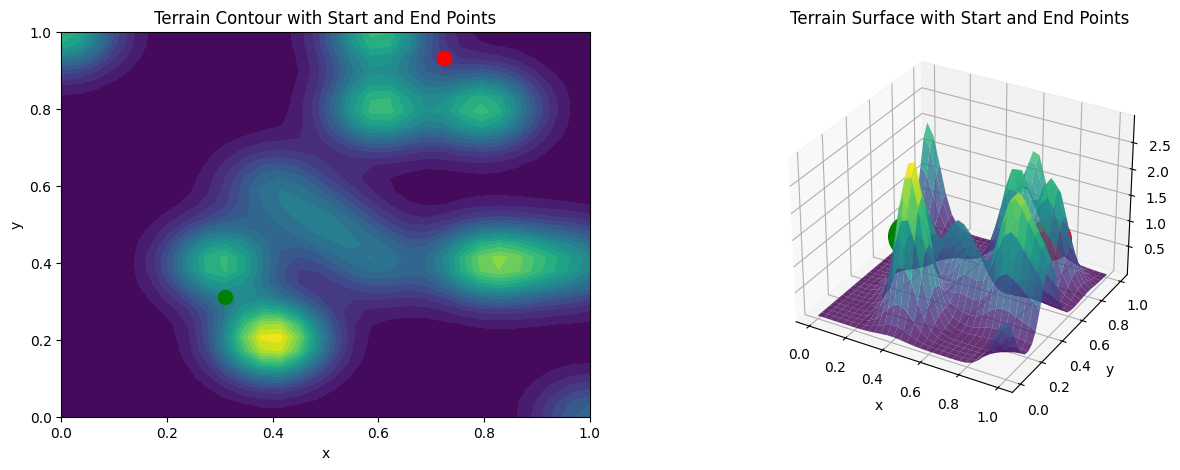

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(15, 5))

# Contour plot
plt.subplot(121)
plt.contourf(X, Y, z, 20, cmap='viridis')
plt.plot(x0[0], x0[1], 'go', markersize=10)
plt.plot(xf[0], xf[1], 'ro', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Terrain Contour with Start and End Points')

# 3D surface plot
ax = plt.subplot(122, projection='3d')
ax.plot_surface(X, Y, z, cmap='viridis', edgecolor='none', alpha=0.8)
ax.plot([x0[0]], [x0[1]], [terrain(x0)], 'go', markersize=30)
ax.plot([xf[0]], [xf[1]], [terrain(xf)], 'ro', markersize=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Terrain Surface with Start and End Points')

plt.show()

Para dos celdas adyacentes, la longitud del camino se puede aproximar utilizando la distancia entre los centros de las celdas.

In [9]:
def cost(x0, x1):
    # estimated path length
    s = math.sqrt((x0[0] - x1[0])**2 +  (x0[1] - x1[1])**2 + (terrain(x0) - terrain(x1))**2)
    return s


### Programación dinámica

In [10]:
import copy

# Inicializa en el punto final
i_x_prev = i_xf
i_x = i_x_prev
V = np.zeros((n,n))

V[i_xf[0], i_xf[1]] = 0
live = [i_x]

# Restringe todos los puntos al terreno dad0
def in_bounds(i_x):
    return (i_x[0]>=0 and i_x[0]<n and i_x[1]>=0 and i_x[1]<n)

# Define todas las acciones posibles
possible_actions = [
    (1, 0), (-1, 0), #left/right
    (0, 1), (0, -1), #up/down
    (1, 1), (1, -1), (-1, -1), (-1, 1) #NE, SE, SW, NW
]

In [11]:
print(live)

[(21, 27)]


In [12]:
# Procesa todos los movimientos restantes (live nodes)
V_data = []
while len(live) > 0:
    new = set()
    for p in live:
        for a in possible_actions:
            pa = (p[0] - a[0], p[1] - a[1]) # Se usa un menos pues la acción es hacia atrás
            if in_bounds(pa):
                V_new = cost(position(p), position(pa)) + V[p[0], p[1]]
                V_old = V[pa[0], pa[1]]
                if V_old == 0 or V_new < V_old:
                    V[pa[0], pa[1]] = V_new
                    new.add(pa)
    live = new
    V_data.append(copy.copy(V))

In [13]:
# Encuentra el camino óptimo, empieza en las condiciones iniciales
# y elige el costo más bajo hacia adelante,
# utilizando el principio de optimalidad de Bellman
p = i_x0
p_hist_opt = [p]
count = 0
while p != i_xf:
    count += 1
    pa_opt = None
    V_old = V[p[0], p[1]]
    for a in possible_actions:
        pa = (p[0] + a[0], p[1] + a[1])
        if in_bounds(pa):
            V_new = V[pa[0], pa[1]]
            if pa_opt is None or pa==i_xf or (V_new < V_opt and V_new < V_old):
                V_opt = V_new
                pa_opt = pa
        if pa == i_xf: break
    if count > 1000: break
    p = pa_opt
    p_hist_opt.append(p)
pos_hist_opt = np.array([position(p) for p in p_hist_opt])

In [14]:
print(p_hist_opt)

[(9, 9), (10, 9), (11, 10), (12, 11), (12, 12), (12, 13), (11, 14), (10, 15), (9, 16), (9, 17), (9, 18), (10, 19), (11, 20), (12, 20), (13, 20), (14, 20), (15, 19), (16, 19), (17, 18), (18, 18), (19, 18), (20, 18), (21, 18), (22, 18), (23, 18), (24, 18), (25, 18), (26, 19), (27, 20), (28, 21), (28, 22), (27, 23), (27, 24), (26, 25), (26, 26), (25, 27), (24, 27), (23, 27), (22, 27), (21, 27)]


<ipython-input-15-64f7857276ef>:34: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  start_point.set_data(pos_hist_opt[frame, 0], pos_hist_opt[frame, 1])
<ipython-input-15-64f7857276ef>:35: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  end_point.set_data(pos_hist_opt[-1, 0], pos_hist_opt[-1, 1])
<ipython-input-15-64f7857276ef>:34: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  start_point.set_data(pos_hist_opt[frame, 0], pos_hist_opt[frame, 1])
<ipython-input-15-64f7857276ef>:35: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  end_point.set_data(pos_hist_opt[-1, 0], pos_hist_opt[-1, 1])


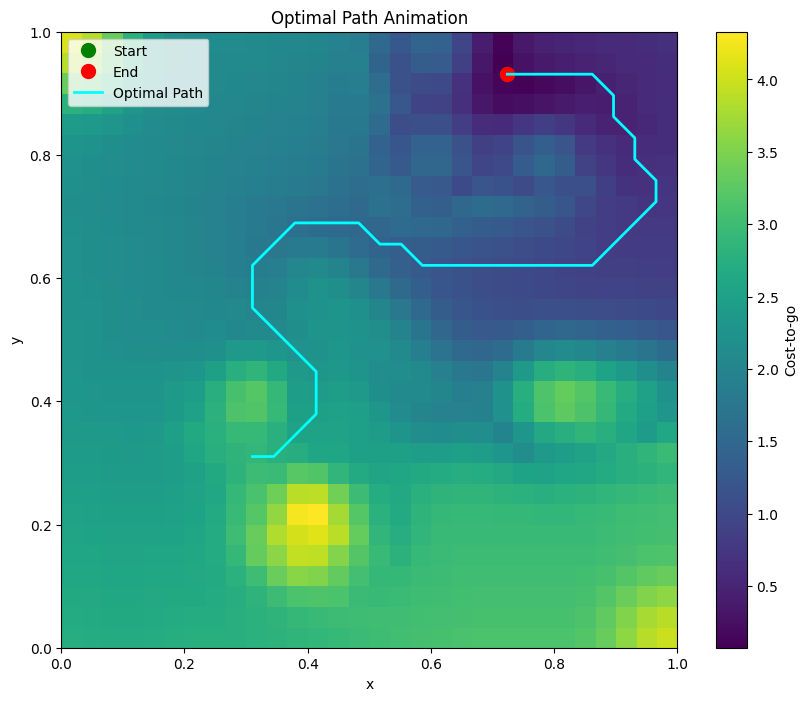

In [15]:
import matplotlib.animation as animation
from IPython.display import HTML

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the cost-to-go graph
im = ax.imshow(V.T, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.colorbar(im, ax=ax, label='Cost-to-go')

# Plot the starting and ending points
start_point, = ax.plot([], [], 'go', markersize=10, label='Start')
end_point, = ax.plot([], [], 'ro', markersize=10, label='End')

# Plot the optimal path
optimal_path, = ax.plot([], [], color='cyan', linewidth=2, label='Optimal Path')

# Set labels and legend
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Optimal Path Animation')
ax.legend()

# Initialize animation parameters
num_frames = len(pos_hist_opt)
frames = []

# Define update function for animation
def update(frame):
    # Update the position of the optimal path
    optimal_path.set_data(pos_hist_opt[:frame+1, 0], pos_hist_opt[:frame+1, 1])

    # Update the position of the starting and ending points
    start_point.set_data(pos_hist_opt[frame, 0], pos_hist_opt[frame, 1])
    end_point.set_data(pos_hist_opt[-1, 0], pos_hist_opt[-1, 1])

    return optimal_path, start_point, end_point

# Generate frames for animation
for i in range(num_frames):
    frames.append(i)

# Create animation
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=True)

# Display animation in HTML
HTML(ani.to_html5_video())

La intensidad del color representa el costo desde cada punto hasta el punto final.


In [18]:
# Modelo de terreno
def terrain(x):
    peaks = [# center, height, sigma
             ((0.3,0.4), 2, 0.1),
             ((1.0,0.0), 1, 0.1),
             ((0.5,0.5), 1, 0.1),
             ((0.0,1.0), 1, 0.1),
             ((0.6,1.0), 2, 0.1),
             ((0.6,0.8), 2, 0.1),
             ((0.8,0.4), 2, 0.1),
             ((0.8,0.8), 2, 0.1),
             ((0.9,0.4), 1, 0.1),
             ((0.4,0.6), 1, 0.1),
             ((0.6,0.4), 1, 0.1),
             ((1.0,0.4), 1, 0.1),
             ((0.4,0.2), 3, 0.1),
             ((0.0,1.0), 1, 0.1),
             ]
    t = 0
    x = np.array(x)

    for peak in peaks:
        xp = np.array(peak[0]).reshape(2, 1)
        h = peak[1]
        sig = peak[2]
        d = x - np.array(xp)
        t += h * np.exp(-np.sum(d**2, axis=0) / sig**2)
    return t

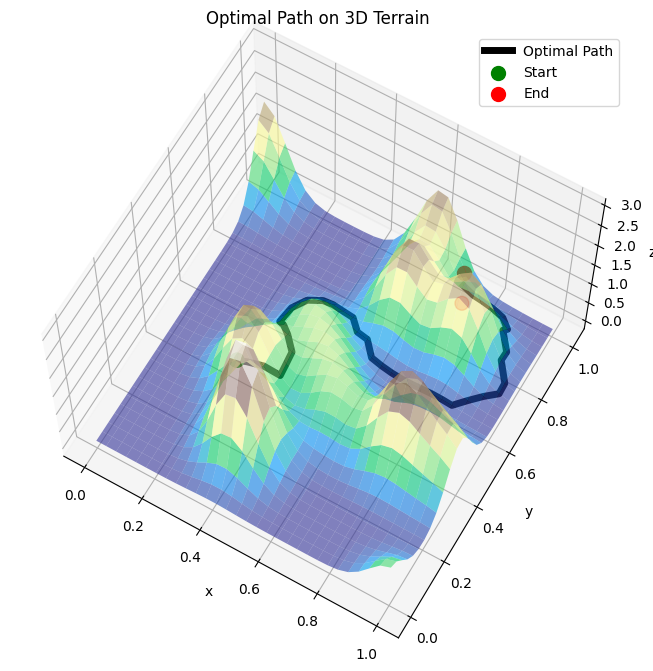

In [19]:
from mpl_toolkits.mplot3d import Axes3D

# Initialize figure and axis for 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Adjust viewing angle
ax.view_init(elev=65)

# Plot the terrain surface
h_terrain = ax.plot_surface(X, Y, z, cmap='terrain', alpha=0.6)

# Plot the optimal path on the terrain
ax.plot(pos_hist_opt[:, 0], pos_hist_opt[:, 1], terrain(pos_hist_opt.T), color='black', linewidth=5, label='Optimal Path')

# Plot the starting and ending points
ax.scatter(x0[0], x0[1], terrain(x0), color='green', s=100, label='Start')
ax.scatter(xf[0], xf[1], terrain(xf), color='red', s=100, label='End')

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Optimal Path on 3D Terrain')
ax.legend()

plt.show()

### Referencias



*   https://github.com/jgoppert/control-systems/blob/master/Bellman%20Equation.ipynb

